# Neural net-based preconditoners for PDE solvers
## PDE Environment: Heat, Wave, Poisson
## Neural Network: Graph Neural Network (GNN)
### Author: Tony Guan

In [1]:
# set ups
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import cg, spilu, LinearOperator
import time
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# define GNN preconditioner

class PreconditionerGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PreconditionerGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_idx = data.x, data.edge_index
        x = self.conv1(x, edge_idx)
        x = torch.relu(x)
        x = self.conv2(x, edge_idx)
        return x

input_dim = 1
hidden_dim = 32
output_dim = 1

model = PreconditionerGNN(input_dim, hidden_dim, output_dim)

In [3]:
#define graph for matrix A

def prepare_graph_data(matrix, preconditioner):
    n = matrix.shape[0]
    edge_idx = torch.tensor([[i, j] for i in range(n) for j in range(n) if matrix[i, j] != 0], dtype=torch.long).t().contiguous()
    x = torch.tensor(matrix.diagonal().reshape(-1, 1), dtype=torch.float32)
    y = torch.tensor(preconditioner.diagonal().reshape(-1, 1), dtype=torch.float32)
    return Data(x=x, edge_index=edge_idx, y=y)

In [4]:
# define CG for GNN

def cg_GNN(A, b, model, tol=1e-5, max_iter=1000):
    n = A.shape[0]
    graph_data = prepare_graph_data(A, np.linalg.inv(np.diag(np.diag(A))))
    model.eval()
    with torch.no_grad():
        M_inv_pred = model(graph_data).squeeze().numpy()
        M_inv_pred = np.diag(M_inv_pred)

    def preconditioner(x):
        return M_inv_pred @ x

    M = LinearOperator((n, n), matvec=preconditioner)
    
    start_time = time.time()
    x, info = cg(A, b, tol=tol, maxiter=max_iter, M=M)
    elapsed_time = time.time() - start_time
    
    return x, info, elapsed_time

In [5]:
# define classic preconditioners

def jacobi(A):
    M_inv = np.linalg.inv(np.diag(np.diag(A)))
    return M_inv

def gauss_seidel(A):
    L = np.tril(A)
    U = np.triu(A, 1)
    M_inv = np.linalg.inv(L + U)
    return M_inv

def incomplete_cholesky(A):
    A_sparse = csc_matrix(A)
    A_ilu = spilu(A_sparse)
    M_inv = np.linalg.inv(A_ilu.L.dot(A_ilu.L.T).toarray())
    return M_inv

In [6]:
# define conjugate gradient for classic preconditioner

def cg_classic(A, b, preconditioner_type, tol=1e-5, max_iter=1000):
    n = A.shape[0]
    M_inv = preconditioner_type(A)

    def preconditioner(x):
        return M_inv @ x

    M = LinearOperator((n, n), matvec=preconditioner)
    
    start_time = time.time()
    x, info = cg(A, b, tol=tol, maxiter=max_iter, M=M)
    elapsed_time = time.time() - start_time
    
    return x, info, elapsed_time

### Heat Equation

The linear second-order PDE for heat in one dimension is:

$$ \frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2} $$

In three dimensions, it is:

$$ \frac{\partial u}{\partial t} = \alpha \Delta u $$

where:
- $ u = u(x,t) $ is the temperature as a function of position x and time t.
- $\alpha $ is the thermal diffusivity that depends on the material.
- $\frac{\partial u}{\partial t} $ is the partial derivative of u with respect to time t.
- $\frac{\partial^2 u}{\partial x^2}$ is the second partial derivative of u  with respect to the spatial coordinate x.
- $ \Delta u $ represents the Laplacian of u, which in three dimensions is given by:

$$ \Delta u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} + \frac{\partial^2 u}{\partial z^2} $$

https://en.wikipedia.org/wiki/Heat_equation

Epoch [1/25], Loss: 1.4974
Epoch [2/25], Loss: 0.7447
Epoch [3/25], Loss: 0.3095
Epoch [4/25], Loss: 0.0953
Epoch [5/25], Loss: 0.0196
Epoch [6/25], Loss: 0.0027
Epoch [7/25], Loss: 0.0005
Epoch [8/25], Loss: 0.0003
Epoch [9/25], Loss: 0.0003
Epoch [10/25], Loss: 0.0003
Epoch [11/25], Loss: 0.0003
Epoch [12/25], Loss: 0.0003
Epoch [13/25], Loss: 0.0003
Epoch [14/25], Loss: 0.0003
Epoch [15/25], Loss: 0.0003
Epoch [16/25], Loss: 0.0003
Epoch [17/25], Loss: 0.0003
Epoch [18/25], Loss: 0.0003
Epoch [19/25], Loss: 0.0003
Epoch [20/25], Loss: 0.0003
Epoch [21/25], Loss: 0.0003
Epoch [22/25], Loss: 0.0003
Epoch [23/25], Loss: 0.0003
Epoch [24/25], Loss: 0.0003
Epoch [25/25], Loss: 0.0003


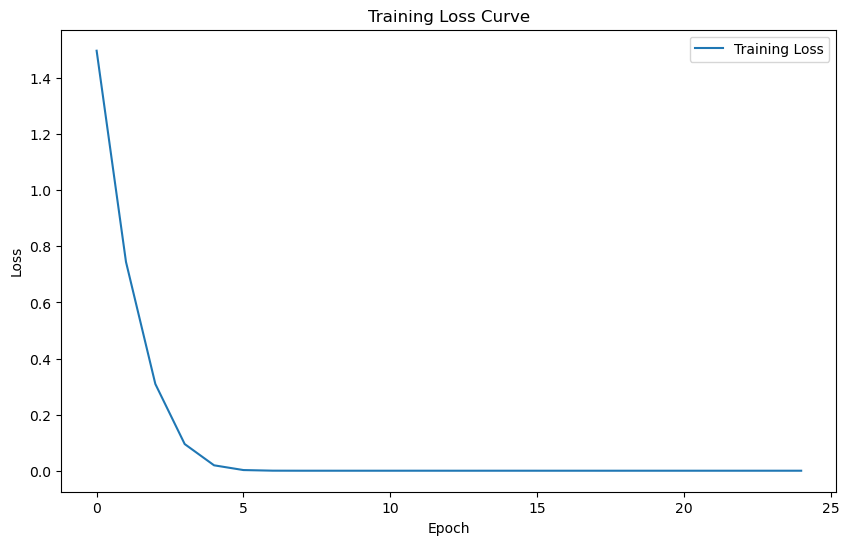

In [7]:
def heat_equation(n, alpha=0.34, dt=0.01, dx=1.0):
    r = alpha * dt / (dx ** 2)
    main_diag = (1 - 2 * r) * np.ones(n)
    off_diag = r * np.ones(n - 1)
    diagonals = [off_diag, main_diag, off_diag]
    offsets = [-1, 0, 1]
    A = diags(diagonals, offsets, shape=(n, n)).toarray()
    b = np.ones(n) + 0.00001 * np.random.randn(n)  # with noise
    return A, b

# define syntheic data
    
def generate_data(num_samples, n_values):
    matrices = []
    preconditioners = []
    for n in n_values:
        for _ in range(num_samples // len(n_values)):
            A, _ = heat_equation(n)
            M_inv = np.linalg.inv(np.diag(np.diag(A)))
            matrices.append(A)
            preconditioners.append(M_inv)
    return matrices, preconditioners

# TRAIN 

n_values_train = [10, 20, 50, 100, 200]
num_samples = 2500
matrices, preconditioners = generate_data(num_samples, n_values_train)

# define loss function and optimzer 

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# load data
data_list = [prepare_graph_data(matrix, preconditioner) for matrix, preconditioner in zip(matrices, preconditioners)]
loader = DataLoader(data_list, batch_size=64, shuffle=True)

#define epoch and store losses
num_epochs = 25
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for data in loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(loader)
    losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [8]:
# TEST 

def test(n_values, num_samples):
    results = []
    for n in n_values:
        
        A_test, b_test = heat_equation(n)
        
         # exact solution
        x_exact = np.linalg.solve(A_test, b_test)

        # measure time and error for each preconditioner
        preconditioners_type = [jacobi, gauss_seidel, incomplete_cholesky]
        preconditioner_names = ["Jacobi", "Gauss-Seidel", "Incomplete Cholesky"]

        for preconditioner, name in zip(preconditioners_type, preconditioner_names):
            x, _, elapsed_time = cg_classic(A_test, b_test, preconditioner)
            error = np.linalg.norm(x - x_exact) / np.linalg.norm(x_exact)
            results.append((n, name, elapsed_time, error))
            print(f"n={n}, Preconditioner={name}, Computation Time={elapsed_time:.4f} seconds, Relative Error={error:.4e}")

        # GNN preconditioner
        x_gnn, _, gnn_time = cg_GNN(A_test, b_test, model)
        gnn_error = np.linalg.norm(x_gnn - x_exact) / np.linalg.norm(x_exact)
        results.append((n, "GNN", gnn_time, gnn_error))
        print(f"n={n}, Preconditioner=GNN, Computation Time={gnn_time:.4f} seconds, Relative Error={gnn_error:.4e}")

        # exact 
        start_time = time.time()
        x_exact = np.linalg.solve(A_test, b_test)
        exact_time = time.time() - start_time
        results.append((n, "Exact", exact_time, 0.0))
        print(f"n={n}, Preconditioner=Exact, Computation Time={exact_time:.4f} seconds, Relative Error=0.0000")

        print("---------------")
    return results

n_values_test = [10, 20, 50, 100, 200]
results = test(n_values_test, num_samples=2000)

# dataframe the result 
df = pd.DataFrame(results, columns=["n", "Preconditioner", "Computation Time (s)", "Relative Error"])

n=10, Preconditioner=Jacobi, Computation Time=0.0003 seconds, Relative Error=4.5409e-06
n=10, Preconditioner=Gauss-Seidel, Computation Time=0.0002 seconds, Relative Error=1.5690e-16
n=10, Preconditioner=Incomplete Cholesky, Computation Time=0.0002 seconds, Relative Error=3.5311e-06
n=10, Preconditioner=GNN, Computation Time=0.0003 seconds, Relative Error=4.1629e-08
n=10, Preconditioner=Exact, Computation Time=0.0000 seconds, Relative Error=0.0000
---------------
n=20, Preconditioner=Jacobi, Computation Time=0.0002 seconds, Relative Error=3.4942e-06
n=20, Preconditioner=Gauss-Seidel, Computation Time=0.0002 seconds, Relative Error=3.5008e-16
n=20, Preconditioner=Incomplete Cholesky, Computation Time=0.0002 seconds, Relative Error=2.5687e-06
n=20, Preconditioner=GNN, Computation Time=0.0003 seconds, Relative Error=9.7055e-06
n=20, Preconditioner=Exact, Computation Time=0.0001 seconds, Relative Error=0.0000
---------------
n=50, Preconditioner=Jacobi, Computation Time=0.0003 seconds, Rela

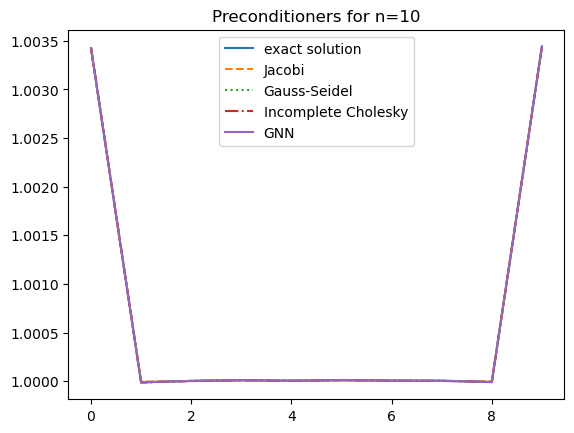

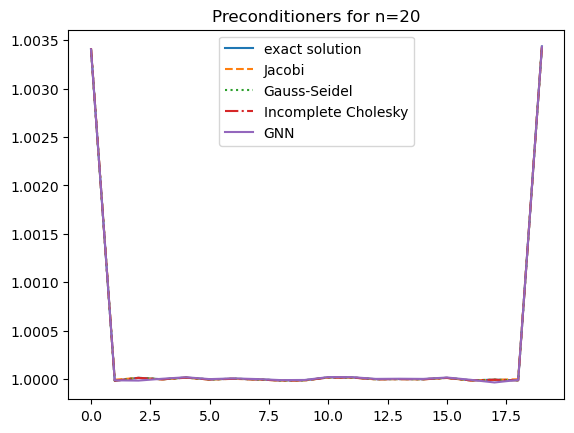

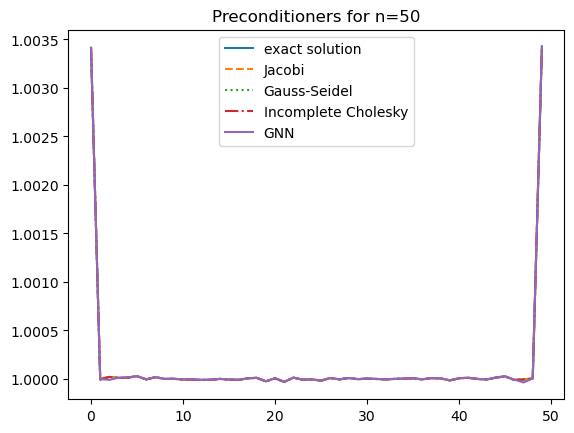

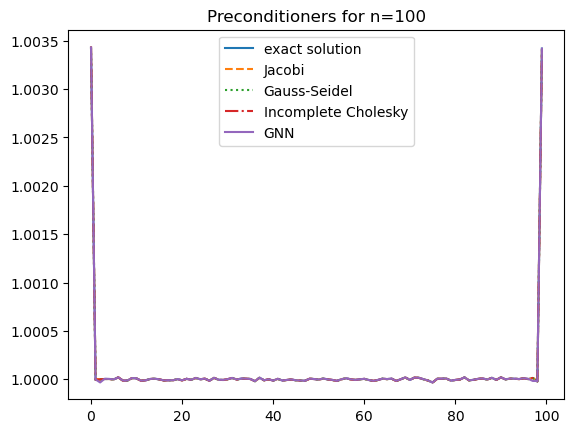

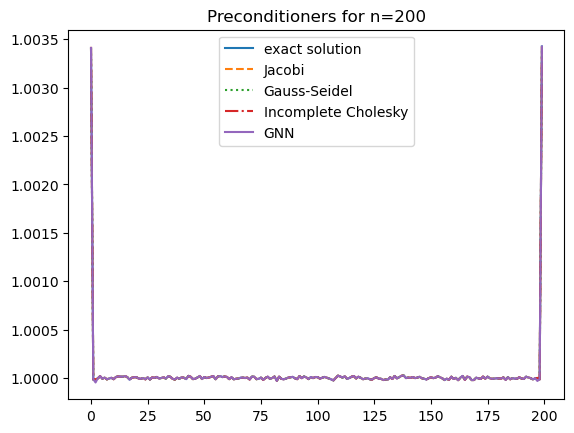

In [9]:
# plot the results

def plot_preconditioners(n_values):
    for n in n_values:
        A_test, b_test = heat_equation(n)

        # exact solution
        x_exact = np.linalg.solve(A_test, b_test)

        # Jacobi
        x_jacobi, _, _ = cg_classic(A_test, b_test, jacobi)

        # Gauss-Seidel
        x_gauss_seidel, _, _ = cg_classic(A_test, b_test, gauss_seidel)

        # incomplete Cholesky
        x_incomplete_cholesky, _, _ = cg_classic(A_test, b_test, incomplete_cholesky)

        # GNN 
        x_gnn, _, _ = cg_GNN(A_test, b_test, model)

        plt.figure()
        plt.plot(x_exact, label='exact solution')
        plt.plot(x_jacobi, label='Jacobi', linestyle='dashed')
        plt.plot(x_gauss_seidel, label='Gauss-Seidel', linestyle='dotted')
        plt.plot(x_incomplete_cholesky, label='Incomplete Cholesky', linestyle='dashdot')
        plt.plot(x_gnn, label='GNN', linestyle='solid')
        plt.title(f'Preconditioners for n={n}')
        plt.legend()
        plt.show()

plot_preconditioners(n_values_test)

### Wave Equation

The linear second-order PDE for wave in one dimension is:

$$ \frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2} $$


In three dimensions, it is:

$$  \frac{\partial^2 u}{\partial t^2} = c^2 \Delta u $$

where:

- $ u = u(x,t) $ is the displacement at position x and time t.
- $ c $ is the speed of the wave
- $ \Delta u $ represents the Laplacian of u, which in three dimensions is given by:

$$ \Delta u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} + \frac{\partial^2 u}{\partial z^2} $$

https://en.wikipedia.org/wiki/Wave_equation

Epoch [1/10], Loss: 0.3909
Epoch [2/10], Loss: 0.0202
Epoch [3/10], Loss: 0.0001
Epoch [4/10], Loss: 0.0001
Epoch [5/10], Loss: 0.0001
Epoch [6/10], Loss: 0.0001
Epoch [7/10], Loss: 0.0001
Epoch [8/10], Loss: 0.0001
Epoch [9/10], Loss: 0.0001
Epoch [10/10], Loss: 0.0001


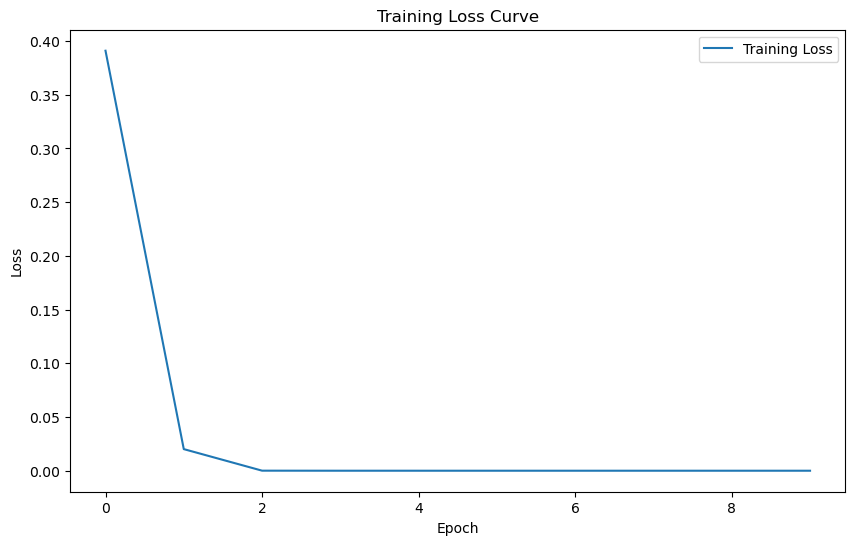

In [10]:
def wave_equation(n, c=1.0, dt=0.01, dx=1):
    r = (c * dt / dx) ** 2
    main_diag = (2 - 2 * r) * np.ones(n)
    off_diag = r * np.ones(n-1)
    diagonals = [off_diag, main_diag, off_diag]
    offsets = [-1, 0, 1]
    A = diags(diagonals, offsets, shape=(n, n)).toarray()
    b = np.ones(n) + 0.00001 * np.random.randn(n)  # with noise
    return A, b

# define syntheic data
    
def generate_data(num_samples, n_values):
    matrices = []
    preconditioners = []
    for n in n_values:
        for _ in range(num_samples // len(n_values)):
            A, _ = wave_equation(n)
            M_inv = np.linalg.inv(np.diag(np.diag(A)))
            matrices.append(A)
            preconditioners.append(M_inv)
    return matrices, preconditioners

# TRAIN 

n_values_train = [10, 20, 50, 100, 200]
num_samples = 2500
matrices, preconditioners = generate_data(num_samples, n_values_train)

# define loss function and optimzer 

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# load data
data_list = [prepare_graph_data(matrix, preconditioner) for matrix, preconditioner in zip(matrices, preconditioners)]
loader = DataLoader(data_list, batch_size=64, shuffle=True)

#define epoch and store losses
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for data in loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(loader)
    losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [11]:
# TEST 

def test(n_values, num_samples):
    results = []
    for n in n_values:
        
        A_test, b_test = wave_equation(n)
        
         # exact solution
        x_exact = np.linalg.solve(A_test, b_test)

        # measure time and error for each preconditioner
        preconditioners_type = [jacobi, gauss_seidel, incomplete_cholesky]
        preconditioner_names = ["Jacobi", "Gauss-Seidel", "Incomplete Cholesky"]

        for preconditioner, name in zip(preconditioners_type, preconditioner_names):
            x, _, elapsed_time = cg_classic(A_test, b_test, preconditioner)
            error = np.linalg.norm(x - x_exact) / np.linalg.norm(x_exact)
            results.append((n, name, elapsed_time, error))
            print(f"n={n}, Preconditioner={name}, Computation Time={elapsed_time:.4f} seconds, Relative Error={error:.4e}")

        # GNN preconditioner
        x_gnn, _, gnn_time = cg_GNN(A_test, b_test, model)
        gnn_error = np.linalg.norm(x_gnn - x_exact) / np.linalg.norm(x_exact)
        results.append((n, "GNN", gnn_time, gnn_error))
        print(f"n={n}, Preconditioner=GNN, Computation Time={gnn_time:.4f} seconds, Relative Error={gnn_error:.4e}")

        # exact 
        start_time = time.time()
        x_exact = np.linalg.solve(A_test, b_test)
        exact_time = time.time() - start_time
        results.append((n, "Exact", exact_time, 0.0))
        print(f"n={n}, Preconditioner=Exact, Computation Time={exact_time:.4f} seconds, Relative Error=0.0000")

        print("---------------")
    return results

n_values_test = [10, 20, 50, 100, 200]
results = test(n_values_test, num_samples=2000)

# dataframe the result 
df = pd.DataFrame(results, columns=["n", "Preconditioner", "Computation Time (s)", "Relative Error"])

n=10, Preconditioner=Jacobi, Computation Time=0.0003 seconds, Relative Error=9.6845e-10
n=10, Preconditioner=Gauss-Seidel, Computation Time=0.0002 seconds, Relative Error=1.7554e-16
n=10, Preconditioner=Incomplete Cholesky, Computation Time=0.0002 seconds, Relative Error=7.8493e-10
n=10, Preconditioner=GNN, Computation Time=0.0003 seconds, Relative Error=5.5324e-10
n=10, Preconditioner=Exact, Computation Time=0.0000 seconds, Relative Error=0.0000
---------------
n=20, Preconditioner=Jacobi, Computation Time=0.0002 seconds, Relative Error=7.4552e-10
n=20, Preconditioner=Gauss-Seidel, Computation Time=0.0001 seconds, Relative Error=3.7813e-16
n=20, Preconditioner=Incomplete Cholesky, Computation Time=0.0002 seconds, Relative Error=1.8894e-09
n=20, Preconditioner=GNN, Computation Time=0.0003 seconds, Relative Error=9.9919e-06
n=20, Preconditioner=Exact, Computation Time=0.0000 seconds, Relative Error=0.0000
---------------
n=50, Preconditioner=Jacobi, Computation Time=0.0002 seconds, Rela

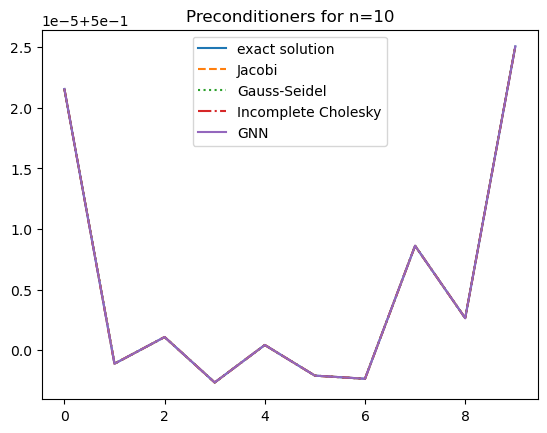

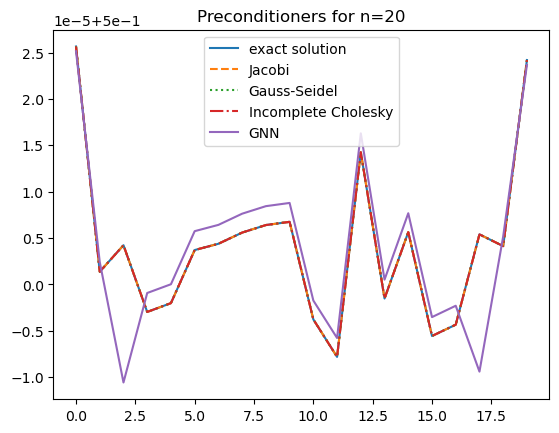

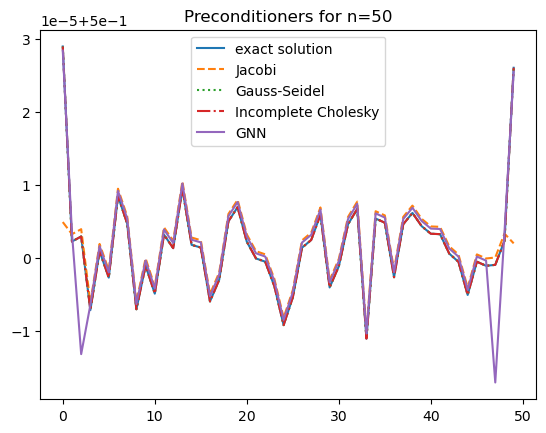

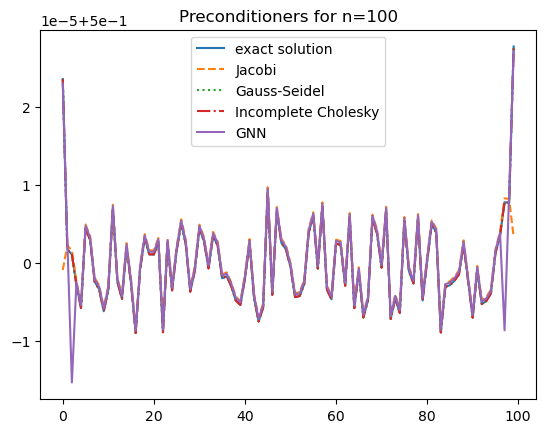

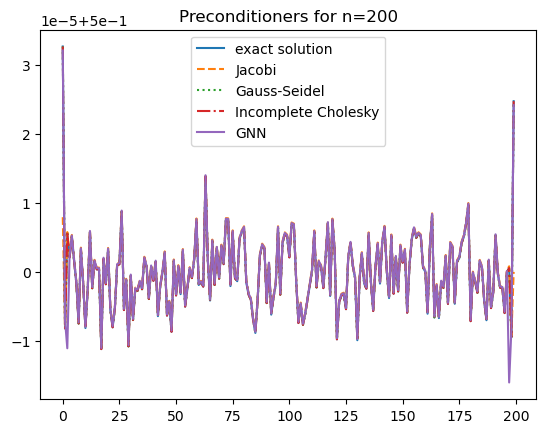

In [12]:
# plot the results

def plot_preconditioners(n_values):
    for n in n_values:
        A_test, b_test = wave_equation(n)

        # exact solution
        x_exact = np.linalg.solve(A_test, b_test)

        # Jacobi
        x_jacobi, _, _ = cg_classic(A_test, b_test, jacobi)

        # Gauss-Seidel
        x_gauss_seidel, _, _ = cg_classic(A_test, b_test, gauss_seidel)

        # incomplete Cholesky
        x_incomplete_cholesky, _, _ = cg_classic(A_test, b_test, incomplete_cholesky)

        # GNN 
        x_gnn, _, _ = cg_GNN(A_test, b_test, model)

        plt.figure()
        plt.plot(x_exact, label='exact solution')
        plt.plot(x_jacobi, label='Jacobi', linestyle='dashed')
        plt.plot(x_gauss_seidel, label='Gauss-Seidel', linestyle='dotted')
        plt.plot(x_incomplete_cholesky, label='Incomplete Cholesky', linestyle='dashdot')
        plt.plot(x_gnn, label='GNN', linestyle='solid')
        plt.title(f'Preconditioners for n={n}')
        plt.legend()
        plt.show()

plot_preconditioners(n_values_test)

### Poission

The linear second-order PDE for Poisson is:

$$ \nabla^2 \phi = f $$

where:
- $ \nabla^2 $ is the Laplace operator.
- $ \phi \$ is real or complex-valued function on a manifold to solve for.
- f  is given

In three-dimensional Cartesian coordinates, the Laplacian is:

$$ \nabla^2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2} $$

https://en.wikipedia.org/wiki/Poisson%27s_equation

Epoch [1/25], Loss: 0.0602
Epoch [2/25], Loss: 0.0011
Epoch [3/25], Loss: 0.0002
Epoch [4/25], Loss: 0.0001
Epoch [5/25], Loss: 0.0001
Epoch [6/25], Loss: 0.0001
Epoch [7/25], Loss: 0.0001
Epoch [8/25], Loss: 0.0001
Epoch [9/25], Loss: 0.0001
Epoch [10/25], Loss: 0.0001
Epoch [11/25], Loss: 0.0001
Epoch [12/25], Loss: 0.0001
Epoch [13/25], Loss: 0.0001
Epoch [14/25], Loss: 0.0001
Epoch [15/25], Loss: 0.0001
Epoch [16/25], Loss: 0.0001
Epoch [17/25], Loss: 0.0001
Epoch [18/25], Loss: 0.0001
Epoch [19/25], Loss: 0.0001
Epoch [20/25], Loss: 0.0001
Epoch [21/25], Loss: 0.0001
Epoch [22/25], Loss: 0.0001
Epoch [23/25], Loss: 0.0001
Epoch [24/25], Loss: 0.0001
Epoch [25/25], Loss: 0.0001


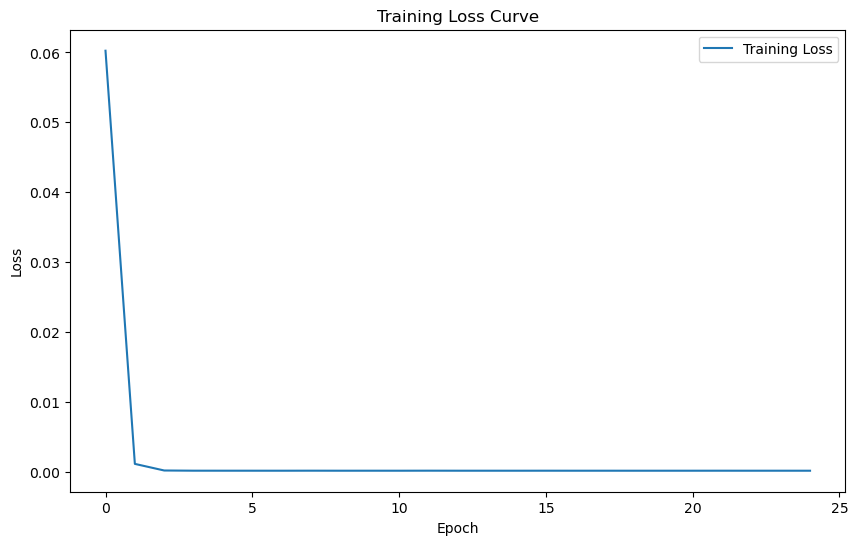

In [13]:
def poisson_equation(n, dx=1.0):
    
    main_diag = -2 * np.ones(n)
    off_diag = np.ones(n - 1)
    diagonals = [off_diag, main_diag, off_diag]
    offsets = [-1, 0, 1]
    A = diags(diagonals, offsets, shape=(n, n)).toarray()
    
    # assume f(x) = 1 
    f = np.ones(n)
    b = f * (dx ** 2)
    
    return A, b

# define syntheic data
    
def generate_data(num_samples, n_values):
    matrices = []
    preconditioners = []
    for n in n_values:
        for _ in range(num_samples // len(n_values)):
            A, _ = poisson_equation(n)
            M_inv = np.linalg.inv(np.diag(np.diag(A)))
            matrices.append(A)
            preconditioners.append(M_inv)
    return matrices, preconditioners

# TRAIN 

n_values_train = [10, 20, 50, 100, 200]
num_samples = 2000
matrices, preconditioners = generate_data(num_samples, n_values_train)

# define loss function and optimzer 

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# load data
data_list = [prepare_graph_data(matrix, preconditioner) for matrix, preconditioner in zip(matrices, preconditioners)]
loader = DataLoader(data_list, batch_size=64, shuffle=True)

#define epoch and store losses
num_epochs = 25
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for data in loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(loader)
    losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [14]:
# TEST 

def test(n_values, num_samples):
    results = []
    for n in n_values:
        
        A_test, b_test = poisson_equation(n)
        
         # exact solution
        x_exact = np.linalg.solve(A_test, b_test)

        # measure time and error for each preconditioner
        preconditioners_type = [jacobi, gauss_seidel, incomplete_cholesky]
        preconditioner_names = ["Jacobi", "Gauss-Seidel", "Incomplete Cholesky"]

        for preconditioner, name in zip(preconditioners_type, preconditioner_names):
            x, _, elapsed_time = cg_classic(A_test, b_test, preconditioner)
            error = np.linalg.norm(x - x_exact) / np.linalg.norm(x_exact)
            results.append((n, name, elapsed_time, error))
            print(f"n={n}, Preconditioner={name}, Computation Time={elapsed_time:.4f} seconds, Relative Error={error:.4e}")

        # GNN preconditioner
        x_gnn, _, gnn_time = cg_GNN(A_test, b_test, model)
        gnn_error = np.linalg.norm(x_gnn - x_exact) / np.linalg.norm(x_exact)
        results.append((n, "GNN", gnn_time, gnn_error))
        print(f"n={n}, Preconditioner=GNN, Computation Time={gnn_time:.4f} seconds, Relative Error={gnn_error:.4e}")

        # exact 
        start_time = time.time()
        x_exact = np.linalg.solve(A_test, b_test)
        exact_time = time.time() - start_time
        results.append((n, "Exact", exact_time, 0.0))
        print(f"n={n}, Preconditioner=Exact, Computation Time={exact_time:.4f} seconds, Relative Error=0.0000")

        print("---------------")
    return results

n_values_test = [10, 20, 50, 100, 200]
results = test(n_values_test, num_samples=100)

# dataframe the result 
df = pd.DataFrame(results, columns=["n", "Preconditioner", "Computation Time (s)", "Relative Error"])

n=10, Preconditioner=Jacobi, Computation Time=0.0005 seconds, Relative Error=8.7417e-17
n=10, Preconditioner=Gauss-Seidel, Computation Time=0.0002 seconds, Relative Error=1.0456e-15
n=10, Preconditioner=Incomplete Cholesky, Computation Time=0.0004 seconds, Relative Error=3.7936e-07
n=10, Preconditioner=GNN, Computation Time=0.0003 seconds, Relative Error=1.2123e-16
n=10, Preconditioner=Exact, Computation Time=0.0000 seconds, Relative Error=0.0000
---------------
n=20, Preconditioner=Jacobi, Computation Time=0.0005 seconds, Relative Error=1.3237e-16
n=20, Preconditioner=Gauss-Seidel, Computation Time=0.0001 seconds, Relative Error=1.4958e-15
n=20, Preconditioner=Incomplete Cholesky, Computation Time=0.0004 seconds, Relative Error=5.5633e-08
n=20, Preconditioner=GNN, Computation Time=0.0005 seconds, Relative Error=2.5711e-16
n=20, Preconditioner=Exact, Computation Time=0.0000 seconds, Relative Error=0.0000
---------------
n=50, Preconditioner=Jacobi, Computation Time=0.0010 seconds, Rela

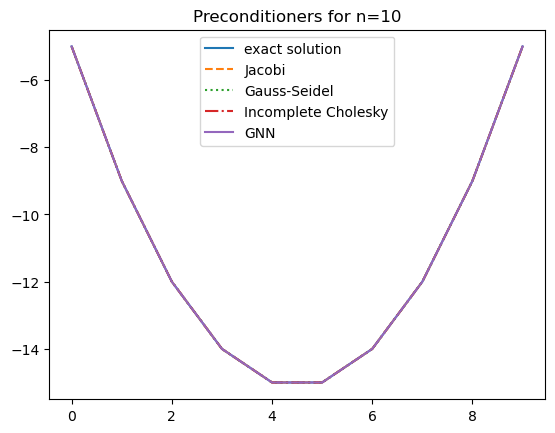

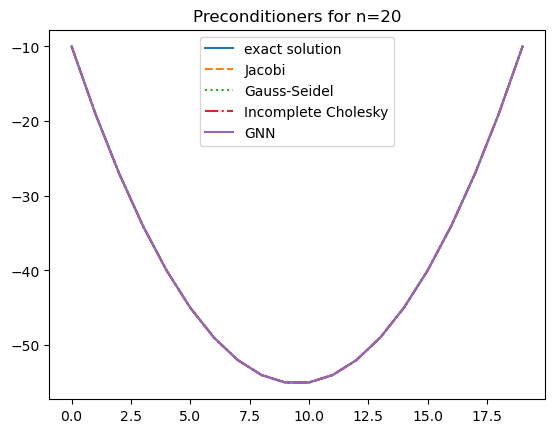

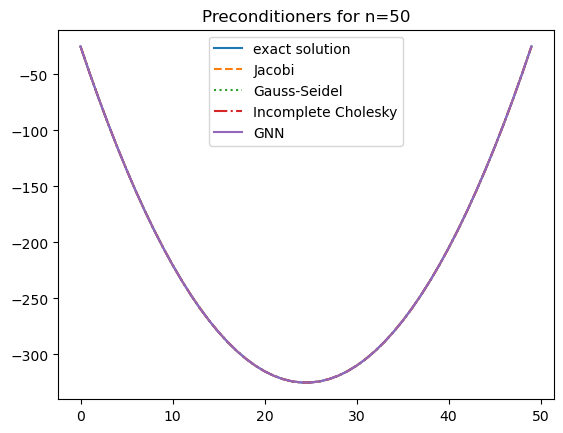

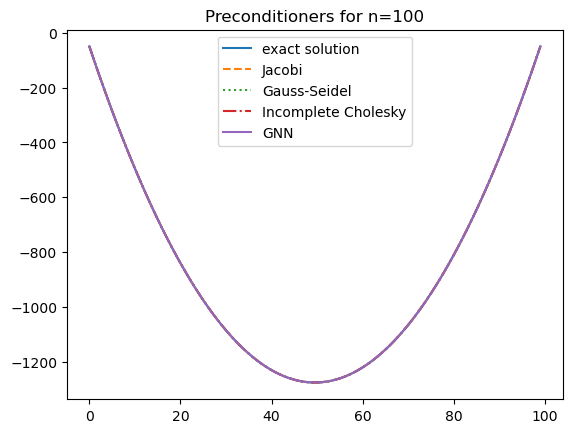

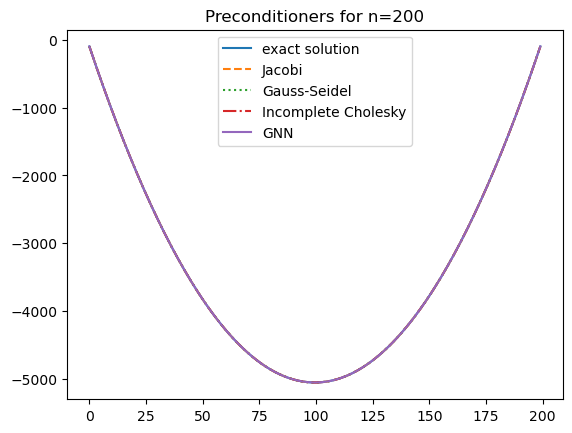

In [15]:
# plot the results

def plot_preconditioners(n_values):
    for n in n_values:
        A_test, b_test = poisson_equation(n)

        # exact solution
        x_exact = np.linalg.solve(A_test, b_test)

        # Jacobi
        x_jacobi, _, _ = cg_classic(A_test, b_test, jacobi)

        # Gauss-Seidel
        x_gauss_seidel, _, _ = cg_classic(A_test, b_test, gauss_seidel)

        # incomplete Cholesky
        x_incomplete_cholesky, _, _ = cg_classic(A_test, b_test, incomplete_cholesky)

        # GNN 
        x_gnn, _, _ = cg_GNN(A_test, b_test, model)

        plt.figure()
        plt.plot(x_exact, label='exact solution')
        plt.plot(x_jacobi, label='Jacobi', linestyle='dashed')
        plt.plot(x_gauss_seidel, label='Gauss-Seidel', linestyle='dotted')
        plt.plot(x_incomplete_cholesky, label='Incomplete Cholesky', linestyle='dashdot')
        plt.plot(x_gnn, label='GNN', linestyle='solid')
        plt.title(f'Preconditioners for n={n}')
        plt.legend()
        plt.show()

plot_preconditioners(n_values_test)